# Assignment 2: Apartments

In this assignment, we practice some data cleaning by extracting a dataset from HTML files. The original data was scraped from [Booli](https://www.booli.se), but it has been preprocessed so that it is easier for you to extract the relevant information. However, as the data originates from a real-world source that has been put forth by actual people, it contains some errors (e.g., missing fields, data that has been misplaced, otherwise nonsensical information).

The data is provided to you as `gothenburg_sold_apartments.zip`, a zip file that contains 12 HTML files, each corresponding to the final prices as announced by realtors, of apartments sold in a specific year in the Gothenburg region.

## Question 1

Implement the function `extract_files` below. It should take the name of the zip file as an argument and return a `dict` that maps years (from 2013 to 2024 as `int`s) to the content of the page (as a **string**).

You must decompress the file inside the function; you only have access to the zip file on the grading server, so you cannot use external tools to decompress it.

**Hints:**
- The ZipFile module is very useful here.
- You may assume all HTML files have been encoded in UTF-8.

In [ ]:
# Codegrade Tag Question1
# Do *not* remove the tag above
# Implement the extract_files function below
import zipfile

def extract_files(zipfilename):
    try:
        result = {}
        with zipfile.ZipFile(zipfilename, 'r') as zf:
            for name in zf.namelist():
                # Check if the filename contains a year between 2013 and 2024
                for year in range(2013, 2025):
                    if str(year) in name and name.endswith(".html"):
                        with zf.open(name) as f:
                            result[year] = f.read().decode("utf-8")
        return result
    except:
        raise NotImplementedError('Not implemented')

data = extract_files('gothenburg_sold_apartments.zip')

## Question 2

This is the beef of this assignment. We convert individual HTML files into Pandas dataframes that contain all of the relevant features of an individual announcement as columns. So, there should be one row for each announcement, and the number of columns is fixed.

You will implement the function `extract_announcements`. The function takes the HTML page in as a string. Use Beautiful Soup to extract the information you need, and return a dataframe.

The dataframe shall contain the following columns (with appropriate types indicated in parentheses):
- `address` (string, the address of the object that has been sold)
- `date` (`datetime64`, the date of sale)
- `district` (string, district where the object is located)
- `municipality` (string, municipality where the object is located)
- `price` (numeric, any numerical type should do, prefer `int`, final sales price in SEK)
- `area` (`float`, can contain non-integer values, area of the apartment in m$^2$)
- `rooms` (`float`, can contain non-integer values, the number of rooms in the apartment)
- `floor` (`float`, the floor of the apartment (i.e., which floor it is located in))

Your function must return a dataframe with exactly the columns above and exactly one row per announcement (in the exact order they are listed in the HTML file).

**Some of the features may be missing in some announcements**, you should then leave the field empty in your dataframe. Here are some specifications on how to deal with the data:
- Date should be stored as an appropriate `datetime64` object, use `pd.to_datetime` to create such objects from strings.
- The location is specified with a string that begins *område* (Swedish for *area* or *region*); all relevant announcements should begin with *Lägenhet* (Swedish for *Apartment*), followed by a middle dot. If there are two things separated by middle dot, assume that the first string is the *district*, the second is the *municipality*. If there is only one middle dot, assume it is followed by the municipality. That is, the string `Lägenhet · Biskopsgården · Göteborg` would be interpreted as an apartment whose *district* is *Biskopsgården* and *municipality* is *Göteborg* whereas `Lägenhet · Partille` would be interpreted as an apartment whose *district* is empty and *municipality* is *Partille*.
- Prices are always integer-valued.
- Area is provided in a string that begins with *storlek* (Swedish for *size*). Areas may contain fractions, such a ½. You should convert these to floating points, e.g., *90½* should be converted to `90.5`.
- Rooms are provided in a string that begins with *rum* (Swedish for *room). They may also contain fractions and should be handled like  the area.
- The floor is provided in a string that begins with *våning* (Swedish for *floor*). Floors may also be negtive. Sometimes floors can be non-integers (e.g., `2,5` is to be interpreted as floor number `2.5`). If the floor contains *BV*, it means *bottenvåning* (Swedish for ground floor); this is to be treated as floor number 0.
- Sometimes the strings can come with nonsensical values (e.g., the price per square meter, or the number of rooms in the string that should encode a floor); these should be ignored and the value treated as missing.

You have been provided with a file called `reference_2014.csv`. This shows the desired output for the file matching the year 2014. Your function will be evaluated against other files by the grader.

**Do not call `extract_announcements` yourself in the following cell**. Do your testing in another cell and do not return those cells to the grader. This is because running the function several times can take a long time and it may lead to a timeout.

Your function is expected to provide an *exact* match to the test data.

**Hints:**
- Beautiful Soup is the expected way to parse the HTML.
- Regular expressions are very useful for extracting the information from formatted strings.
- Take care in handling missing values! When you construct the dataframe, the canonical way to represent missing values is with a `None` object or a `nan` floating-point value. Specifically, the values `0.0`, `0`, or `""` are all well-defined values that are **not** missing.

In [ ]:
# Codegrade Tag Question2
# Do *not* remove the tag above
# Implement the extract_announcements function below

import pandas as pd
import re
from bs4 import BeautifulSoup
from typing import Optional, Tuple, List, Dict

_SV_MONTHS = {
    "januari": 1, "februari": 2, "mars": 3, "april": 4, "maj": 5, "juni": 6,
    "juli": 7, "augusti": 8, "september": 9, "oktober": 10, "november": 11, "december": 12
}

# Map common Unicode vulgar fractions to decimal strings
_FRACTIONS = {
    "¼": "0.25", "½": "0.5", "¾": "0.75",
    "⅐": "0.142857", "⅑": "0.111111", "⅒": "0.1",
    "⅓": "0.333333", "⅔": "0.666667",
    "⅕": "0.2", "⅖": "0.4", "⅗": "0.6", "⅘": "0.8",
    "⅙": "0.166667", "⅚": "0.833333",
    "⅛": "0.125", "⅜": "0.375", "⅝": "0.625", "⅞": "0.875",
}

def _clean_spaces(s: str) -> str:
    """Normalize whitespace (convert NBSP, collapse spaces)."""
    return re.sub(r"\s+", " ", (s or "").replace("\xa0", " ")).strip()

def _parse_swedish_date(text: str) -> Optional[pd.Timestamp]:
    """
    Parse dates like '30 december 2023' into pd.Timestamp (datetime64).
    Returns None if not parseable.
    """
    if not text:
        return None
    
    text = _clean_spaces(text).lower()
    m = re.search(r"(\d{1,2})\s+([a-zåäö]+)\s+(\d{4})", text)
    if not m:
        return None
    day, month_word, year = int(m.group(1)), m.group(2), int(m.group(3))
    month = _SV_MONTHS.get(month_word)
    if not month:
        return None
    
    try:
        return pd.to_datetime(f"{year:04d}-{month:02d}-{day:02d}", utc=False)
    
    except Exception:
        return None

def _replace_unicode_fractions(num_str: str) -> str:
    """
    Replace Unicode fraction characters with decimals, preserving an integer prefix.
    Example: '47½' -> '47.5'; '1⅜' -> '1.375'
    """
    if not num_str:
        return num_str
    
    # If the string contains any standalone fraction char (no dot/comma), merge with integer part if present
    for frac_char, dec in _FRACTIONS.items():
        if frac_char in num_str:
            # If it looks like '47½' -> join as 47 + decimal part
            num_str = num_str.replace(frac_char, f"+{dec}")

    # After substitution, evaluate simple expressions like '47+0.5'
    # Keep only first such expression if multiple
    expr_match = re.match(r"^\s*(-?\d+)(?:\+([0-9.]+))?", num_str)
    if expr_match:
        integer = float(expr_match.group(1))
        frac = float(expr_match.group(2)) if expr_match.group(2) else 0.0
        return str(integer + frac)
    
    return num_str

def _to_float(num_text: str) -> Optional[float]:
    """
    Extract a float from a string that may contain spaces, decimal commas, and unicode fractions.
    Returns None if nothing plausible is found.
    """
    if not num_text:
        return None
    s = _clean_spaces(num_text)

    # First, try replacing unicode fractions in the vicinity of digits
    s = _replace_unicode_fractions(s)

    # Replace decimal comma with dot (Swedish formatting uses comma)
    s = s.replace(",", ".")

    # Extract first plausible number (allow negative, allow decimals)
    m = re.search(r"(-?\d+(?:\.\d+)?)", s)
    if not m:
        return None
    
    try:
        return float(m.group(1))
    
    except Exception:
        return None

def _parse_price(text: str) -> Optional[int]:
    """
    Parse prices like '2 450 000 kr'. Ignore nonsensical price-per-sqm etc.
    Returns None if not parseable.
    """
    if not text:
        return None
    s = _clean_spaces(text).lower()

    # Ignore explicit per-square-meter indications
    if "kr/m" in s or "kr per m" in s or "/m²" in s:
        return None

    # Keep digits only to parse integer; Swedish uses spaces for thousands
    digits = re.sub(r"[^\d]", "", s)
    if not digits:
        return None
    
    try:
        value = int(digits)
    except Exception:
        return None

    # Sanity range to filter out accidental tiny numbers etc.
    if value < 100_000 or value > 200_000_000:
        return None
    
    return value

def _parse_floor(text: str) -> Optional[float]:
    """
    Parse floor from strings like 'vån 3', 'vån -1', 'vån 2,5', or 'BV' (→ 0).
    Returns None if not parseable or if the content is clearly nonsensical.
    """
    if not text:
        return None
    s = _clean_spaces(text).upper()

    # Common nonsense guards
    if "KR" in s or "M²" in s or "RUM" in s:
        return None

    # Bottenvåning
    if "BV" in s:
        return 0.0

    # Decimal comma -> dot
    s = s.replace(",", ".")

    m = re.search(r"(-?\d+(?:\.\d+)?)", s)
    if not m:
        return None
    
    try:
        val = float(m.group(1))
    except Exception:
        return None

    # Sanity range: allow quite tall towers but avoid absurd values
    if val < -10 or val > 200:
        return None
    
    return val

def _parse_rooms(text: str) -> Optional[float]:
    """
    Parse number of rooms; accepts fractions (e.g., '1½ rum').
    """
    if not text:
        return None
    s = _clean_spaces(text).lower()

    # Guard against nonsense
    if "kr" in s or "m²" in s or "vån" in s:
        return None

    val = _to_float(s)
    if val is None:
        return None
    
    # Sanity: typical range
    if val <= 0 or val > 15:
        return None
    
    return val

def _parse_area(text: str) -> Optional[float]:
    """
    Parse area in m²; accepts fractions and decimal commas.
    """
    if not text:
        return None
    s = _clean_spaces(text).lower()

    # Guard against nonsense
    if "kr" in s or "rum" in s or "vån" in s:
        return None

    val = _to_float(s)
    if val is None:
        return None
    # Sanity: area should be positive and not crazy
    if val <= 0 or val > 1000:
        return None
    return val

def _parse_location(text: str) -> Tuple[Optional[str], Optional[str]]:
    """
    Parse 'område:' strings like:
      'Lägenhet · Biskopsgården · Göteborg' -> ('Biskopsgården', 'Göteborg')
      'Lägenhet · Partille' -> (None, 'Partille')
    If not starting with 'Lägenhet', returns (None, None).
    """
    if not text:
        return (None, None)
    s = _clean_spaces(text)

    # Split by middle dot (U+00B7). Fallback: also split by ' · ' robustly.
    parts = [p.strip() for p in s.split("·")]

    if not parts[0].lower().startswith("lägenhet"):
        # Not a relevant announcement type per spec
        return (None, None)

    # Everything after 'Lägenhet' are location pieces
    tail = parts[1:]
    if not tail:
        return (None, None)

    if len(tail) == 1:
        # Only municipality provided
        return (None, tail[0])
    else:
        # District, Municipality (take only the first two after Lägenhet)
        district = tail[0] or None
        municipality = tail[1] or None
        return (district, municipality)

def _extract_label_value(p_tag) -> Tuple[str, str]:
    """
    Given a <p><strong>label:</strong> value</p>,
    return ('label', 'value') lowercasing the label and stripping punctuation.
    """
    strong = p_tag.find("strong")
    label = _clean_spaces(strong.get_text()) if strong else ""
    
    # Get the whole p's text and strip the label from the front
    raw = _clean_spaces(p_tag.get_text())

    # Remove the label prefix (with or without colon)
    pattern = r"^\s*"+re.escape(label.rstrip(":"))+r":?\s*"
    value = re.sub(pattern, "", raw, flags=re.I).strip()
    return label.rstrip(":").lower(), value

def extract_announcements(page):
    try:
        soup = BeautifulSoup(page, "html.parser")
        cards = soup.select(".property-card")

        rows: List[Dict] = []
        for c in cards:
            # Address/title
            title_el = c.select_one(".property-title")
            address = _clean_spaces(title_el.get_text()) if title_el else None

            # Collect labeled fields under .property-details
            labels = {}
            for p in c.select(".property-details p"):
                key, value = _extract_label_value(p)
                labels[key] = value

            # Parse fields
            dt = _parse_swedish_date(labels.get("datum"))
            district, municipality = _parse_location(labels.get("område"))
            price = _parse_price(labels.get("pris"))
            area = _parse_area(labels.get("storlek"))
            rooms = _parse_rooms(labels.get("rum"))
            floor = _parse_floor(labels.get("våning"))

            rows.append({
                "address": address,
                "date": dt,
                "district": district,
                "municipality": municipality,
                "price": price,
                "area": area,
                "rooms": rooms,
                "floor": floor,
            })

        # Build DataFrame in the exact required column order
        cols = ["address", "date", "district", "municipality", "price", "area", "rooms", "floor"]
        df = pd.DataFrame(rows, columns=cols)

        # Enforce dtypes
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        # Use pandas nullable integer for 'price' so missing values are allowed
        df["price"] = pd.to_numeric(df["price"], errors="coerce").fillna(0)
        df["floor"] = pd.to_numeric(df["floor"], errors="coerce")
        df["area"] = pd.to_numeric(df["area"], errors="coerce")
        df["rooms"] = pd.to_numeric(df["rooms"], errors="coerce")

        return df
    except: 
        raise NotImplementedError('Not implemented')

## Question 3

Use your `extract_announcements` and `extract_files` functions to create a dataframe that contains the data from apartment sales in 2023. Store your dataframe in a variable called `df_2023`.

Then, select a subset of the announcements where `municipality` is equal to Göteborg. Store this dataframe as `df_2023_gothenburg`.

This is a separate question for technical reasons.

In [34]:
# Codegrade Tag Question3
# Do *not* remove the tag above
# Write your code below

data = extract_files('gothenburg_sold_apartments.zip')
df_2023 = extract_announcements(data[2023])
df_2023_gothenburg = df_2023[df_2023["municipality"] == "Göteborg"]
df_2023_gothenburg

,address,date,district,municipality,price,area,rooms,floor
1,Kabelgatan 35A,2023-12-30,Majorna,Göteborg,1700000,37.0,1.0,3.0
2,Haråsgatan 21,2023-12-30,Majorna,Göteborg,3000000,55.5,2.0,5.0
4,Räntmästaregatan 21A,2023-12-29,Centrum,Göteborg,3600000,60.0,3.0,1.0
5,Uggleberget 26,2023-12-29,Hovås,Göteborg,6000000,95.0,4.0,3.0
6,Ebbe Lieberathsgatan 6C,2023-12-29,Johanneberg,Göteborg,2600000,55.0,2.0,2.0
...,...,...,...,...,...,...,...,...
6815,Ingrid Wallbergs gata 51,2023-06-19,Kviberg,Göteborg,2375000,47.0,2.0,3.0
6816,Norra Skeppspromenaden 4,2023-06-19,Eriksberg,Göteborg,3695000,74.0,2.0,4.0
6817,Färgfabriksgatan 6,2023-06-19,Kvillebäcken,Göteborg,4400000,99.0,4.0,6.0
6819,Bildradiogatan 8B,2023-06-19,Järnbrott,Göteborg,1850000,34.0,1.0,1.0


## Question 4

Implement the function `five_point_summary` below. The function should compute a 5-point summary of the values of a Pandas `Series`. That is, an individual column of a dataframe.

The function should return a `Series` object that has the following elements (index should consist of strings corresponding to these elements) in the specified order:
- `min`, the minimum value of the elements in `s`
- `Q1`, the 1st quartile of the elements in `s`
- `median`, the median of the elements in `s`
- `Q3`, the 3rd quartile of the elements in `s`
- `max`, the maximum of the elements in `s`

Use your function to compute the five-point summary of the prices of apartments sold in Gothenburg in 2023, and store the result in `price_2023_gothenburg_fps`.


In [ ]:
# Codegrade Tag Question4
# Do *not* remove the tag above
# Implement the function five_point_summary below, and compute the summary for df_2023_gothenburg

def five_point_summary(s):
    try:
        return pd.Series({
            "min": s.min(),
            "Q1": s.quantile(0.25),
            "median": s.median(),
            "Q3": s.quantile(0.75),
            "max": s.max()
        })
    except:
        raise NotImplementedError('Not implemented')
    
price_2023_gothenburg_fps = five_point_summary(df_2023_gothenburg["price"])
price_2023_gothenburg_fps

min         620000.0
Q1         2100000.0
median     2775000.0
Q3         3770000.0
max       19500000.0
dtype: float64

## Question 5

Construct a histogram of apartment prices in Gothenburg in 2023. Use *Sturges' rule* to determine the correct number of bins. Create a new axis object for plotting the histogram and store it in a variable called `ax`. Store your histogram counts and bin thresholds in variables called `counts` and `bins`, respectively. Label axes and give the plot a meaningful title. Set the ticks on the $x$-axis to be in *Millions of kronor* (MSEK). Place the ticks and the tick labels exactly 2.5 MSEK apart, up to and including 20.0 MSEK, with exactly 1 decimal point.

**Hints:**
- You can create a new axis with `plt.subplots()`.
- Calling the `hist()` method of the axis will return the required counts and bin thresholds.
- The number of bins in `counts` should match the correct number of bins as determined by Sturges' rule.
- The number of bin thresholds in `bins` should be exactly one higher: `counts[0]` corresponds to the number of values in the interval from `bins[0]` to `bins[1]` and so on.
- The tick labels should be **exactly** 0.0, 2.5, ..., 20.0.
- The autograder checks technical requirements very strictly because this is in part a technical exercise in producing a plot with given details and characteristics.

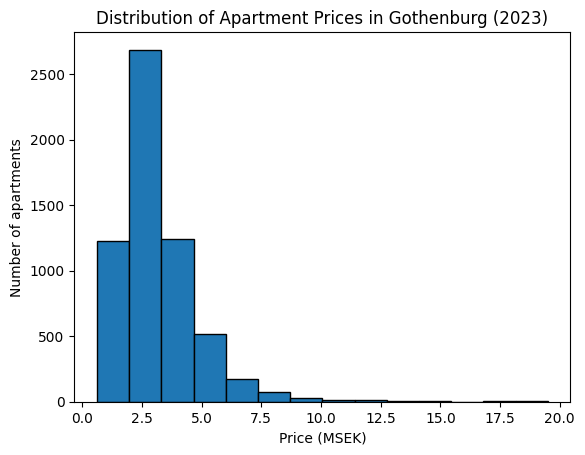

In [36]:
# Codegrade Tag Question5
# Do *not* remove the tag above
# Write your code below

import matplotlib.pyplot as plt
import numpy as np

# Extract the price column, dropping missing values
prices = df_2023_gothenburg["price"]

# Number of bins using Sturges' rule
n = len(prices)
num_bins = int(np.ceil(1 + np.log2(n)))

# Create figure and axis
fig, ax = plt.subplots()

# Plot histogram
counts, bins, patches = ax.hist(prices, bins=num_bins, edgecolor="black")

# Axis labels and title
ax.set_xlabel("Price (MSEK)")
ax.set_ylabel("Number of apartments")
ax.set_title("Distribution of Apartment Prices in Gothenburg (2023)")

# Format x-axis ticks in millions (MSEK), step 2.5
xticks = np.arange(0, 20.0 + 2.5, 2.5)
ax.set_xticks(xticks * 1e6)  # scale back to kronor
ax.set_xticklabels([f"{x:.1f}" for x in xticks])
plt.show()

## Question 6

Create a scatter plot that shows the relationship between the area of the apartment (on the $x$-axis) and the price of the apartment (on the $y$-axis). Add color to your points such that you colorize the apartments by the number of rooms. Label $x$ and $y$ axes and give the plot a title. Also add a legend that shows the relationship between the color and the number of rooms.

Create a new axis object for your plot and call it `ax` again.

**Hints:**
- If you have trouble fitting the legend in the plot, try adjusting the `figsize` parameter of `plt.subplots()`.
- Color can be added to `scatter` with the `c` parameter; the value passed here should have exactly one **integer** color number of reach data point (`x` and `y` coordinates).
- Due to the previous, do note that there are non-integer room counts, so you may need to map, e.g., room counts 1.0, 1.5, 2.0, 2.5, ... to 0, 1, 2, 3, respectively.
- You can extract **legend element handles** from a `scatter` object (the objet returned by `ax.scatter()`) with `scatter.legend_elements()`. You can use this to adjust the labels of your legend.
- The autograder expects that the legend consists of strings `1.0`, `1.5`, `2.0`, ... for the room counts, so please use exactly these strings as legend labels.

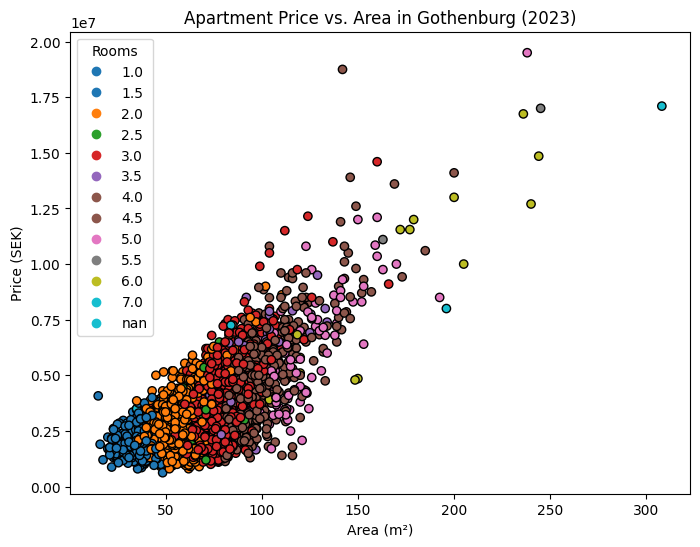

In [37]:
# Codegrade Tag Question6
# Do *not* remove the tag above
# Write your code below

import matplotlib.pyplot as plt
import numpy as np

# Extract relevant columns and drop rows with missing values
data = df_2023_gothenburg[["area", "price", "rooms"]]

# Rooms may contain non-integer values (e.g., 1.5), so we keep them as floats
room_counts = data["rooms"].astype(float)

# Map unique room counts to integers for color coding
unique_rooms = np.sort(room_counts.unique())
room_to_int = {room: i for i, room in enumerate(unique_rooms)}
colors = room_counts.map(room_to_int)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot
scatter = ax.scatter(
    data["area"], data["price"],
    c=colors,
    cmap="tab10", edgecolor="black"
)

# Axis labels and title
ax.set_xlabel("Area (m²)")
ax.set_ylabel("Price (SEK)")
ax.set_title("Apartment Price vs. Area in Gothenburg (2023)")

# Create legend
handles, _ = scatter.legend_elements()
labels = [f"{room:.1f}" for room in unique_rooms]
ax.legend(handles, labels, title="Rooms")
plt.show()

## Question 7

Create a new dataframe called `df_2023_gothenburg_w_psqm` that contains all the same data as `df_2023_gothenburg`, but in addition contains a new column called `price per sqm`. As suggested, this should contain the price per square meter for each apartment sold (that is, the price divided by the area).

In [38]:
# Codegrade Tag Question7
# Do *not* remove the tag above
# Write your code below

# Make a copy of the original DataFrame
df_2023_gothenburg_w_psqm = df_2023_gothenburg.copy()

# Compute price per square meter
df_2023_gothenburg_w_psqm["price per sqm"] = (
    df_2023_gothenburg_w_psqm["price"] / df_2023_gothenburg_w_psqm["area"]
)

df_2023_gothenburg_w_psqm

,address,date,district,municipality,price,area,rooms,floor,price per sqm
1,Kabelgatan 35A,2023-12-30,Majorna,Göteborg,1700000,37.0,1.0,3.0,45945.945946
2,Haråsgatan 21,2023-12-30,Majorna,Göteborg,3000000,55.5,2.0,5.0,54054.054054
4,Räntmästaregatan 21A,2023-12-29,Centrum,Göteborg,3600000,60.0,3.0,1.0,60000.000000
5,Uggleberget 26,2023-12-29,Hovås,Göteborg,6000000,95.0,4.0,3.0,63157.894737
6,Ebbe Lieberathsgatan 6C,2023-12-29,Johanneberg,Göteborg,2600000,55.0,2.0,2.0,47272.727273
...,...,...,...,...,...,...,...,...,...
6815,Ingrid Wallbergs gata 51,2023-06-19,Kviberg,Göteborg,2375000,47.0,2.0,3.0,50531.914894
6816,Norra Skeppspromenaden 4,2023-06-19,Eriksberg,Göteborg,3695000,74.0,2.0,4.0,49932.432432
6817,Färgfabriksgatan 6,2023-06-19,Kvillebäcken,Göteborg,4400000,99.0,4.0,6.0,44444.444444
6819,Bildradiogatan 8B,2023-06-19,Järnbrott,Göteborg,1850000,34.0,1.0,1.0,54411.764706


## Question 8

Create a bar chart where you show average price per square meter conditioned on the number of rooms in the apartment.

That is, there should be one bar for each room count (1.0, 1.5, 2.0, 2.5, ...) that shows the average. However, if there are **no** rooms matching that number of rooms, then there should not be an empty bar (that is, if there are no apartments with 4.5 rooms, the next bar after 4.0 should be simply 5.0).

Label axes and give the plot a title. The $x$ axis ticks should match exactly the number of rooms (just as in the legend of Question 6). That its, there should be one tick per each room, and the tick label should be *exactly* 1.0, 1.5 etc.

Again, create a new axis object and call it `ax`.

**Hints:**
- `groupby` is a useful method.
- Again, the autograder will be super picky about the ticks and tick labels. Make them correct.

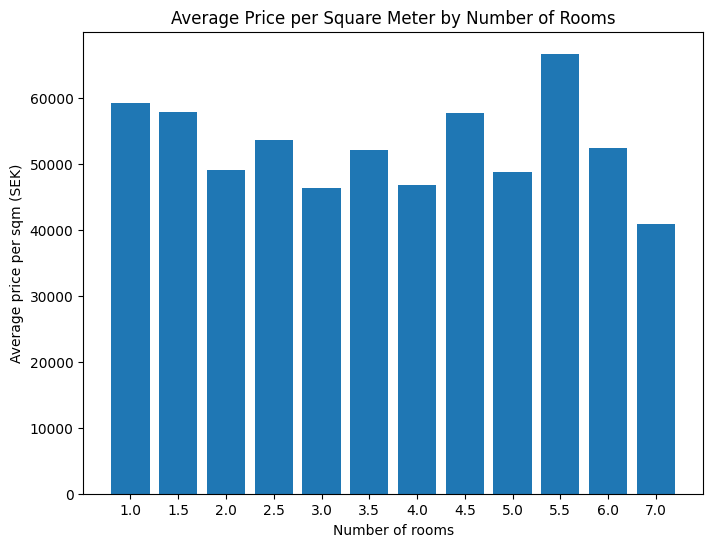

In [39]:
# Codegrade Tag Question8
# Do *not* remove the tag above
# Write your code below

import matplotlib.pyplot as plt

# Group by number of rooms and compute mean price per sqm
avg_psqm_by_rooms = (
    df_2023_gothenburg_w_psqm
    .dropna(subset=["rooms", "price per sqm"])
    .groupby("rooms")["price per sqm"]
    .mean()
)

# Sort by room count (important for x-axis order)
avg_psqm_by_rooms = avg_psqm_by_rooms.sort_index()

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Bar chart
ax.bar(avg_psqm_by_rooms.index.astype(str), avg_psqm_by_rooms.values)

# Axis labels and title
ax.set_xlabel("Number of rooms")
ax.set_ylabel("Average price per sqm (SEK)")
ax.set_title("Average Price per Square Meter by Number of Rooms")

# Ensure x-axis ticks match exactly the room counts (e.g., "1.0", "1.5", ...)
ax.set_xticks([str(r) for r in avg_psqm_by_rooms.index.astype(float)])
ax.set_xticklabels([f"{r:.1f}" for r in avg_psqm_by_rooms.index.astype(float)])
plt.show()

## Question 9

We will do something similar but with the district information in this case. Compute the mean price per square meter **by the district**. Create a `Series` that contains the average price per square meter of the five cheapest districts in a variable called `cheapest`. The Series should have the names of the districts as index and the price as values. Likewise, store a Series of the five most expensive districts in a variable called `most_expensive`.

Then, create a new axis called `ax` and plot a barplot where you show (in ascending order from left to right) the price per square meter in the five cheapest and five most expensive districts. That is, there should be ten such bars in total, and they should become higher towards the right.

Label axes and give the figure a title. Place $x$ ticks below each bar such that it shows which district the bar corresponds to. Make sure that the district names are legible.

**Hints:**
- `groupby()` is again useful
- So is `sort_values`
- The `set_xticks()` function has a parameter called `rotation` that can be useful for making the text legible
- The aforementioned `rotation` parameter is only available if you pass the tick labels at the same time as ticks through `set_xticks`; otherwise, the `rotation` parameter must be passed to `set_xticklabels`

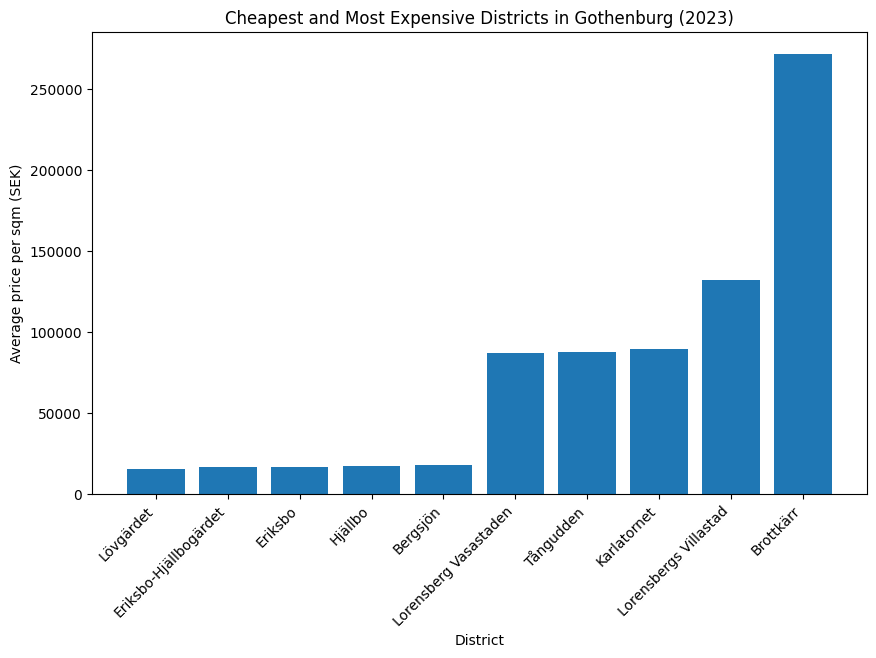

In [40]:
# Codegrade Tag Question9
# Do *not* remove the tag above
# Write your code below

import matplotlib.pyplot as plt

# Compute average price per sqm by district
avg_psqm_by_district = (
    df_2023_gothenburg_w_psqm
    .dropna(subset=["district", "price per sqm"])
    .groupby("district")["price per sqm"]
    .mean()
)

# Find cheapest 5 and most expensive 5
cheapest = avg_psqm_by_district.sort_values().head(5)
most_expensive = avg_psqm_by_district.sort_values().tail(5)

# Combine them into one Series (cheapest first, then most expensive)
combined = pd.concat([cheapest, most_expensive])

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot
ax.bar(combined.index, combined.values)

# Axis labels and title
ax.set_xlabel("District")
ax.set_ylabel("Average price per sqm (SEK)")
ax.set_title("Cheapest and Most Expensive Districts in Gothenburg (2023)")

# Set xticks with rotation for legibility
ax.set_xticks(range(len(combined.index)))
ax.set_xticklabels(combined.index, rotation=45, ha="right")
plt.show()

## Question 10

Discuss the findings above. What do they tell us about the housing market in Gothenburg? Which factors influence the prices of apartments, how, and why? Find out about the different districts, for example.

Write 2–4 paragraphs.

*Write your answer here*

In 2023, most apartments in Gothenburg were priced below 5 MSEK, with the largest share concentrated around 2.5 MSEK. Only very few apartments in Gothenburg exceeded 10 MSEK.

Apartment size correlates with the number of rooms: more rooms generally mean a larger floor area and a higher total price. However, the number of rooms has little influence on the average price per square meter. Smaller apartment are typically more affordable, while larger ones are more expensive.

The city’s cheapest apartments are located in Lövgärdet, Hjällbo, Eriksbo-Hjällbogärdet, Eriksbo, and Bergsjön, where prices fall below 2,000 SEK per square meter. By contrast, the most expensive neighborhoods include Brottkärr, Lorensbergs Villastad, Karlatornet, Tångudden, and Lorensberg Vasastaden. Among them, Brottkärr is the the priciest, with prices surpassing 250,000 SEK per square meter.